# VRP Analysis — Stage 3: Regime Dependence

Stage 2 showed filters improve Sharpe, but OOS beat IS. That's suspicious.

Hypothesis: filter effectiveness depends on crisis *type*. COVID was short & sharp (filter helps). GFC was prolonged (filter hurts — you miss recovery premium).

Let's quantify this.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
# data (same as before)
spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)
vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)

get = lambda d, t: d['Close'][t] if isinstance(d.columns, pd.MultiIndex) else d['Close']

df = pd.DataFrame({'spy': get(spy, 'SPY'), 'vix': get(vix, '^VIX')})
df['ret'] = np.log(df['spy'] / df['spy'].shift(1))
df['rv'] = df['ret'].rolling(21).std() * np.sqrt(252) * 100
df['vrp'] = df['vix'] - df['rv']
df = df.dropna()

# monthly
m = df.resample('ME').last().copy()
m['fwd_rv'] = df['ret'].resample('ME').std().shift(-1) * np.sqrt(252) * 100
m['pnl'] = (m['vix']**2 - m['fwd_rv']**2) / 100
m = m.dropna(subset=['pnl'])

scale = 0.10 / (m['pnl'].std() * np.sqrt(12))
m['base'] = m['pnl'] * scale
m['vix25'] = m['pnl'] * (m['vix'] <= 25).astype(float) * scale

print(f"{len(df)} daily, {len(m)} monthly")

C:\Users\cvand\AppData\Local\Temp\ipykernel_35508\1059312929.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2006-01-01', end='2024-12-31', progress=False)


4759 daily, 226 monthly


C:\Users\cvand\AppData\Local\Temp\ipykernel_35508\1059312929.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start='2006-01-01', end='2024-12-31', progress=False)


## 1. Identify stress episodes

Define a "stress episode" as consecutive days with VIX > 25. Measure duration, peak VIX, shape.

In [3]:
# identify stress episodes
df['stressed'] = (df['vix'] > 25).astype(int)
df['episode'] = (df['stressed'] != df['stressed'].shift(1)).cumsum()
df['episode'] = df['episode'] * df['stressed']  # 0 for non-stressed

# get episode stats
episodes = []
for ep_id in df[df['episode'] > 0]['episode'].unique():
    ep = df[df['episode'] == ep_id]
    
    # find when peak occurs (as % of episode duration)
    peak_idx = ep['vix'].idxmax()
    peak_position = (ep.index.get_loc(peak_idx) + 1) / len(ep)
    
    episodes.append({
        'start': ep.index[0],
        'end': ep.index[-1],
        'days': len(ep),
        'peak_vix': ep['vix'].max(),
        'mean_vix': ep['vix'].mean(),
        'peak_position': peak_position,  # 0=start, 1=end
        'entry_vix': ep['vix'].iloc[0],
        'exit_vix': ep['vix'].iloc[-1]
    })

eps = pd.DataFrame(episodes)
eps = eps[eps['days'] >= 5]  # ignore tiny blips
print(f"{len(eps)} stress episodes (≥5 days)")
eps.head(10)

33 stress episodes (≥5 days)


,start,end,days,peak_vix,mean_vix,peak_position,entry_vix,exit_vix
1,2007-08-09,2007-08-21,9,30.830000,28.011111,0.666667,26.480000,25.250000
10,2008-01-17,2008-01-31,10,31.010000,28.145000,0.300000,28.459999,26.200001
11,2008-02-04,2008-02-12,7,28.969999,27.542857,0.428571,25.990000,26.330000
15,2008-03-06,2008-03-31,17,32.240002,27.392353,0.470588,27.549999,25.610001
18,2008-07-09,2008-07-17,7,28.540001,26.491429,0.714286,25.230000,25.010000
20,2008-09-12,2009-07-16,212,80.860001,44.006462,0.235849,25.660000,25.420000
21,2009-07-28,2009-08-03,5,25.920000,25.500000,0.800000,25.010000,25.559999
24,2009-08-17,2009-08-24,6,27.889999,25.928333,0.166667,27.889999,25.139999
25,2009-08-31,2009-09-08,6,29.150000,27.006667,0.333333,26.010000,25.620001
27,2009-09-29,2009-10-06,6,28.680000,26.715000,0.666667,25.190001,25.700001


In [4]:
# classify shape: V-shaped (peak early) vs U-shaped (peak late/middle)
# V-shape: spikes fast, recovers slow (peak_position < 0.3)
# U-shape: grinds up, peak late (peak_position > 0.5)

eps['shape'] = pd.cut(eps['peak_position'], bins=[0, 0.35, 0.65, 1.0], labels=['V-shape', 'Plateau', 'Inverted-V'])
eps['severity'] = pd.cut(eps['peak_vix'], bins=[25, 30, 40, 100], labels=['Mild', 'Moderate', 'Severe'])
eps['duration'] = pd.cut(eps['days'], bins=[0, 20, 60, 500], labels=['Short', 'Medium', 'Long'])

print("\nBy shape:")
print(eps.groupby('shape', observed=True).agg({'days': 'mean', 'peak_vix': 'mean', 'start': 'count'}).round(1))

print("\nBy duration:")
print(eps.groupby('duration', observed=True).agg({'days': 'mean', 'peak_vix': 'mean', 'start': 'count'}).round(1))


By shape:
            days  peak_vix  start
shape                            
V-shape     35.9      42.2     14
Plateau     17.1      34.0     10
Inverted-V   7.9      29.9      9

By duration:
           days  peak_vix  start
duration                        
Short       8.9      31.8     24
Medium     35.1      39.0      7
Long      142.0      81.8      2


In [5]:
# visualize major episodes
major = eps[eps['days'] >= 20].copy()
print(f"\n{len(major)} major episodes (≥20 days):")
print(major[['start', 'end', 'days', 'peak_vix', 'shape', 'duration']].to_string())


10 major episodes (≥20 days):
        start        end  days   peak_vix    shape duration
20 2008-09-12 2009-07-16   212  80.860001  V-shape     Long
32 2010-05-06 2010-06-17    30  45.790001  Plateau   Medium
41 2011-08-04 2011-10-27    60  48.000000  V-shape   Medium
42 2011-10-31 2011-12-15    33  36.160000  V-shape   Medium
58 2020-02-24 2020-06-04    72  82.690002  V-shape     Long
59 2020-06-08 2020-07-17    29  40.790001  V-shape   Medium
62 2020-08-31 2020-10-08    28  33.599998  V-shape   Medium
78 2022-02-17 2022-03-17    20  36.450001  Plateau    Short
79 2022-04-22 2022-06-01    28  34.750000  Plateau   Medium
85 2022-09-13 2022-11-03    38  33.630001  Plateau   Medium


## 2. Filter effectiveness by episode type

For each stress episode: what was base P&L vs filtered P&L?

In [6]:
# calc P&L during each episode window (monthly granularity)
ep_results = []

for _, ep in eps[eps['days'] >= 10].iterrows():  # episodes ≥10 days
    # get monthly returns during episode + 1 month after (recovery)
    start = ep['start'] - pd.Timedelta(days=5)  # buffer
    end = ep['end'] + pd.Timedelta(days=35)  # include recovery month
    
    mask = (m.index >= start) & (m.index <= end)
    if mask.sum() == 0:
        continue
    
    base_pnl = m.loc[mask, 'base'].sum()
    filt_pnl = m.loc[mask, 'vix25'].sum()
    
    ep_results.append({
        'start': ep['start'],
        'days': ep['days'],
        'peak_vix': ep['peak_vix'],
        'shape': ep['shape'],
        'duration': ep['duration'],
        'base_pnl': base_pnl,
        'filt_pnl': filt_pnl,
        'filter_helped': filt_pnl > base_pnl,
        'improvement': filt_pnl - base_pnl
    })

ep_pnl = pd.DataFrame(ep_results)
print(f"Analyzed {len(ep_pnl)} episodes\n")
print(ep_pnl[['start', 'days', 'peak_vix', 'shape', 'base_pnl', 'filt_pnl', 'improvement']].round(3).to_string())

Analyzed 16 episodes

        start  days  peak_vix       shape  base_pnl  filt_pnl  improvement
0  2008-01-17    10     31.01     V-shape     0.012     0.000       -0.012
1  2008-03-06    17     32.24     Plateau     0.023     0.009       -0.015
2  2008-09-12   212     80.86     V-shape    -0.133     0.000        0.133
3  2010-05-06    30     45.79     Plateau     0.049     0.000       -0.049
4  2010-06-22    12     34.54     Plateau     0.044     0.010       -0.034
5  2011-08-04    60     48.00     V-shape     0.001     0.000       -0.001
6  2011-10-31    33     36.16     V-shape     0.036     0.020       -0.016
7  2015-08-21    11     40.74     V-shape     0.031     0.018       -0.012
8  2020-02-24    72     82.69     V-shape    -0.166     0.000        0.166
9  2020-06-08    29     40.79     V-shape     0.054     0.022       -0.032
10 2020-08-31    28     33.60     V-shape     0.065     0.000       -0.065
11 2020-10-12    19     40.28  Inverted-V     0.064     0.015       -0.049
12 

In [7]:
# aggregate by episode characteristics
print("Filter effectiveness by DURATION:")
print(ep_pnl.groupby('duration', observed=True).agg({
    'base_pnl': 'mean',
    'filt_pnl': 'mean', 
    'improvement': 'mean',
    'filter_helped': 'mean',
    'start': 'count'
}).round(3))

print("\nFilter effectiveness by SHAPE:")
print(ep_pnl.groupby('shape', observed=True).agg({
    'base_pnl': 'mean',
    'filt_pnl': 'mean',
    'improvement': 'mean', 
    'filter_helped': 'mean',
    'start': 'count'
}).round(3))

Filter effectiveness by DURATION:
          base_pnl  filt_pnl  improvement  filter_helped  start
duration                                                       
Long        -0.149     0.000        0.149            1.0      2
Medium       0.033     0.007       -0.026            0.0      7
Short        0.029     0.007       -0.022            0.0      7

Filter effectiveness by SHAPE:
            base_pnl  filt_pnl  improvement  filter_helped  start
shape                                                            
Inverted-V     0.064     0.015       -0.049          0.000      1
Plateau        0.025     0.002       -0.022          0.000      6
V-shape       -0.009     0.007        0.016          0.222      9


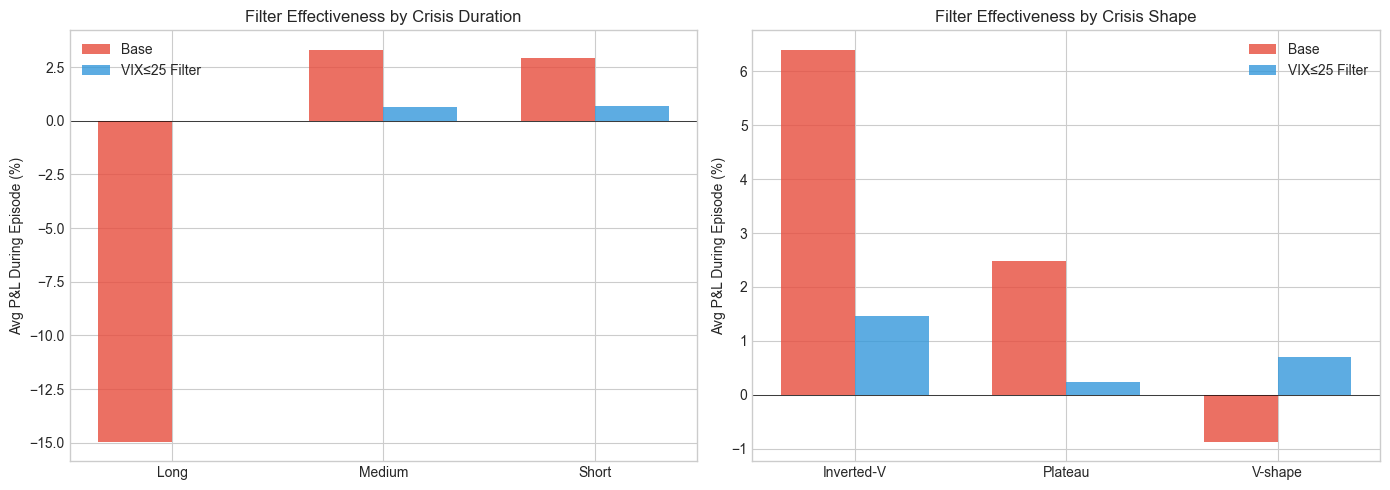

In [8]:
# visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# by duration
dur_agg = ep_pnl.groupby('duration', observed=True)[['base_pnl', 'filt_pnl']].mean()
x = np.arange(len(dur_agg))
w = 0.35
axes[0].bar(x - w/2, dur_agg['base_pnl']*100, w, label='Base', color='#e74c3c', alpha=0.8)
axes[0].bar(x + w/2, dur_agg['filt_pnl']*100, w, label='VIX≤25 Filter', color='#3498db', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(dur_agg.index)
axes[0].set_ylabel('Avg P&L During Episode (%)')
axes[0].set_title('Filter Effectiveness by Crisis Duration')
axes[0].legend()
axes[0].axhline(0, color='black', lw=0.5)

# by shape  
shape_agg = ep_pnl.groupby('shape', observed=True)[['base_pnl', 'filt_pnl']].mean()
x = np.arange(len(shape_agg))
axes[1].bar(x - w/2, shape_agg['base_pnl']*100, w, label='Base', color='#e74c3c', alpha=0.8)
axes[1].bar(x + w/2, shape_agg['filt_pnl']*100, w, label='VIX≤25 Filter', color='#3498db', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(shape_agg.index)
axes[1].set_ylabel('Avg P&L During Episode (%)')
axes[1].set_title('Filter Effectiveness by Crisis Shape')
axes[1].legend()
axes[1].axhline(0, color='black', lw=0.5)

plt.tight_layout()
plt.savefig('filter_by_crisis_type.png', dpi=150)
plt.show()

## 3. The whipsaw problem

When VIX spikes, the filter exits. But VRP is often *highest* right after crises (mean reversion). Do we miss the best months?

In [9]:
# VRP conditional on prior month's VIX
m['vix_lag'] = m['vix'].shift(1)
m['vix_bucket'] = pd.cut(m['vix_lag'], bins=[0, 15, 20, 25, 35, 100], labels=['<15', '15-20', '20-25', '25-35', '>35'])

cond_vrp = m.groupby('vix_bucket', observed=True).agg(
    next_month_pnl=('base', 'mean'),
    next_month_std=('base', 'std'),
    count=('base', 'count')
)
cond_vrp['sharpe'] = cond_vrp['next_month_pnl'] / cond_vrp['next_month_std'] * np.sqrt(12)

print("Next month's P&L conditional on current VIX:")
print(cond_vrp.round(3))

Next month's P&L conditional on current VIX:
            next_month_pnl  next_month_std  count  sharpe
vix_bucket                                               
<15                  0.002           0.005     74   1.455
15-20               -0.001           0.034     72  -0.052
20-25               -0.002           0.049     34  -0.175
25-35                0.014           0.014     33   3.554
>35                  0.016           0.030     12   1.802


In [10]:
# the months we filter OUT (vix > 25) — what happens next?
filtered_out = m[m['vix'] > 25].copy()
stayed_in = m[m['vix'] <= 25].copy()

print(f"Months filtered out: {len(filtered_out)}")
print(f"Months stayed in: {len(stayed_in)}")

# what was the FOLLOWING month's P&L after being filtered out?
filtered_out['next_pnl'] = m['base'].shift(-1)

print(f"\nAfter being filtered out (VIX>25):")
print(f"  Next month avg P&L: {filtered_out['next_pnl'].mean()*100:.2f}%")
print(f"  Next month win rate: {(filtered_out['next_pnl'] > 0).mean()*100:.0f}%")

print(f"\nWhen stayed in (VIX≤25):")
print(f"  Same month avg P&L: {stayed_in['base'].mean()*100:.2f}%")
print(f"  Same month win rate: {(stayed_in['base'] > 0).mean()*100:.0f}%")

Months filtered out: 45
Months stayed in: 181

After being filtered out (VIX>25):
  Next month avg P&L: 1.44%
  Next month win rate: 80%

When stayed in (VIX≤25):
  Same month avg P&L: 0.35%
  Same month win rate: 82%


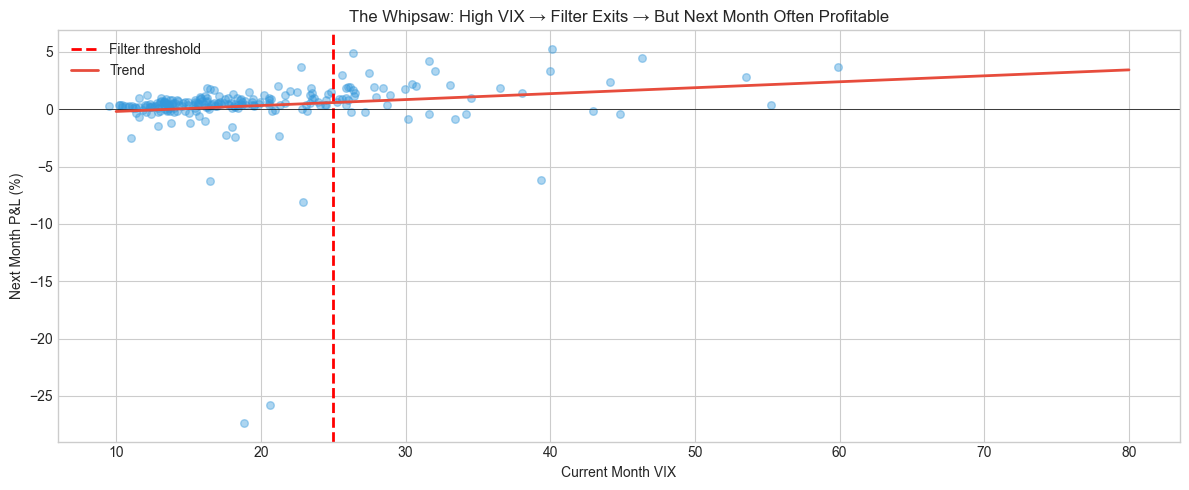

In [11]:
# visualize the "whipsaw"
fig, ax = plt.subplots(figsize=(12, 5))

# scatter: this month's VIX vs next month's P&L
ax.scatter(m['vix'], m['base'].shift(-1)*100, alpha=0.4, s=30, color='#3498db')
ax.axvline(25, color='red', ls='--', lw=2, label='Filter threshold')
ax.axhline(0, color='black', lw=0.5)

# add trend line (align data first)
tmp = pd.DataFrame({'x': m['vix'], 'y': m['base'].shift(-1)*100}).dropna()
z = np.polyfit(tmp['x'], tmp['y'], 1)
p = np.poly1d(z)
x_line = np.linspace(10, 80, 100)
ax.plot(x_line, p(x_line), color='#e74c3c', lw=2, label=f'Trend')

ax.set_xlabel('Current Month VIX')
ax.set_ylabel('Next Month P&L (%)')
ax.set_title('The Whipsaw: High VIX → Filter Exits → But Next Month Often Profitable')
ax.legend()

plt.tight_layout()
plt.savefig('whipsaw_problem.png', dpi=150)
plt.show()

## 4. Regime persistence

If VIX > 25 today, how long until it drops back below? This determines how much you miss.

In [12]:
# time to re-entry after filter triggers
df['above_25'] = df['vix'] > 25

reentry_times = []
i = 0
while i < len(df):
    if df['above_25'].iloc[i]:
        # find when we drop back below
        j = i + 1
        while j < len(df) and df['above_25'].iloc[j]:
            j += 1
        if j < len(df):
            reentry_times.append(j - i)
        i = j
    else:
        i += 1

reentry = pd.Series(reentry_times)
print(f"Days until re-entry (VIX drops back below 25):")
print(f"  Mean: {reentry.mean():.0f} days")
print(f"  Median: {reentry.median():.0f} days")
print(f"  75th pct: {reentry.quantile(0.75):.0f} days")
print(f"  90th pct: {reentry.quantile(0.90):.0f} days")
print(f"  Max: {reentry.max():.0f} days")

Days until re-entry (VIX drops back below 25):
  Mean: 9 days
  Median: 2 days
  75th pct: 6 days
  90th pct: 20 days
  Max: 212 days


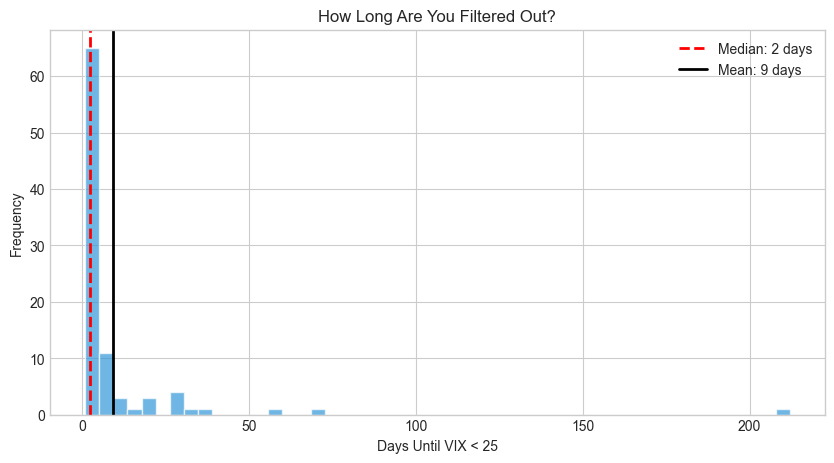

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(reentry, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
ax.axvline(reentry.median(), color='red', ls='--', lw=2, label=f'Median: {reentry.median():.0f} days')
ax.axvline(reentry.mean(), color='black', ls='-', lw=2, label=f'Mean: {reentry.mean():.0f} days')
ax.set_xlabel('Days Until VIX < 25')
ax.set_ylabel('Frequency')
ax.set_title('How Long Are You Filtered Out?')
ax.legend()
plt.savefig('reentry_distribution.png', dpi=150)
plt.show()

## 5. Why OOS looked so good

Quantify: how "filter-friendly" was each period?

In [14]:
# characterize each period
periods = [
    ('2006-2009 (GFC)', '2006-01-01', '2009-12-31'),
    ('2010-2014', '2010-01-01', '2014-12-31'),
    ('2015-2018', '2015-01-01', '2018-12-31'),
    ('2019-2024 (OOS)', '2019-01-01', '2024-12-31')
]

period_stats = []
for name, start, end in periods:
    mask = (m.index >= start) & (m.index <= end)
    mp = m[mask]
    dp = df[(df.index >= start) & (df.index <= end)]
    
    # count stress episodes in period
    n_episodes = len(eps[(eps['start'] >= start) & (eps['start'] <= end)])
    avg_episode_len = eps[(eps['start'] >= start) & (eps['start'] <= end)]['days'].mean()
    
    period_stats.append({
        'period': name,
        'months': len(mp),
        'pct_vix_above_25': (dp['vix'] > 25).mean() * 100,
        'avg_vix': dp['vix'].mean(),
        'n_episodes': n_episodes,
        'avg_episode_days': avg_episode_len,
        'base_sharpe': (mp['base'].mean() / mp['base'].std() * np.sqrt(12)) if len(mp) > 1 else np.nan,
        'filt_sharpe': (mp['vix25'].mean() / mp['vix25'].std() * np.sqrt(12)) if len(mp) > 1 and mp['vix25'].std() > 0 else np.nan,
        'filter_improvement': None  # calc below
    })
    period_stats[-1]['filter_improvement'] = period_stats[-1]['filt_sharpe'] - period_stats[-1]['base_sharpe']

ps = pd.DataFrame(period_stats).set_index('period')
print(ps.round(2).to_string())

                 months  pct_vix_above_25  avg_vix  n_episodes  avg_episode_days  base_sharpe  filt_sharpe  filter_improvement
period                                                                                                                        
2006-2009 (GFC)      47             32.96    23.90          11             26.36        -0.07         0.06                0.12
2010-2014            60             13.20    18.59           6             24.33         1.63         2.61                0.98
2015-2018            48              4.17    15.06           4              7.75         0.92         0.73               -0.19
2019-2024 (OOS)      71             20.74    20.41          12             23.08         0.37         2.13                1.75


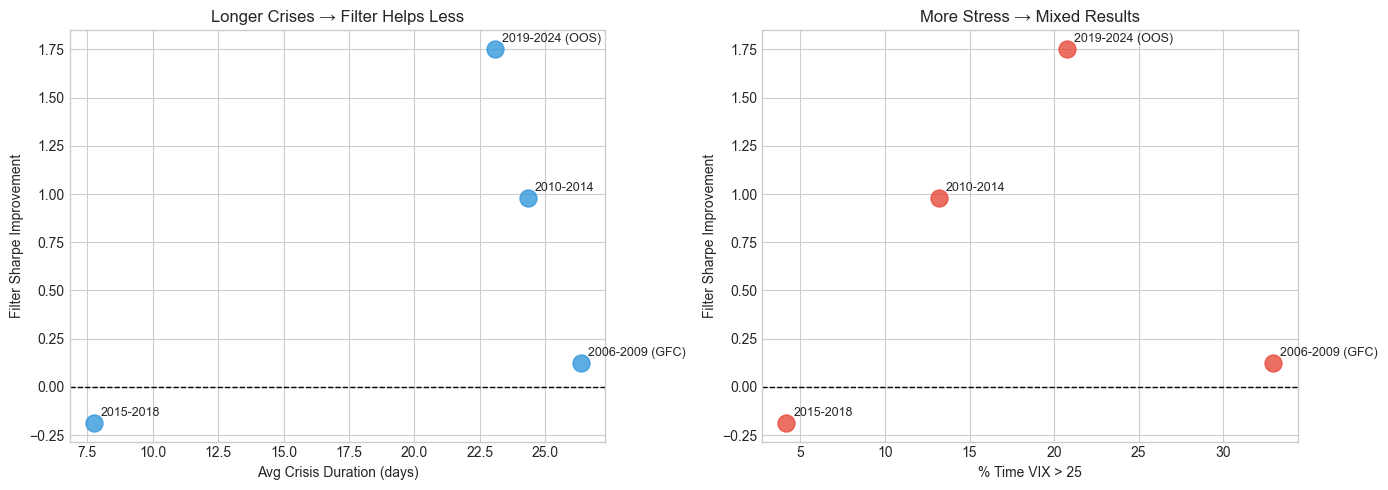

In [15]:
# key insight: filter improvement vs episode characteristics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# filter improvement vs avg episode length
axes[0].scatter(ps['avg_episode_days'], ps['filter_improvement'], s=150, color='#3498db', alpha=0.8)
for idx, row in ps.iterrows():
    axes[0].annotate(idx, (row['avg_episode_days'], row['filter_improvement']), 
                     textcoords="offset points", xytext=(5,5), fontsize=9)
axes[0].axhline(0, color='black', ls='--', lw=1)
axes[0].set_xlabel('Avg Crisis Duration (days)')
axes[0].set_ylabel('Filter Sharpe Improvement')
axes[0].set_title('Longer Crises → Filter Helps Less')

# filter improvement vs % time VIX > 25
axes[1].scatter(ps['pct_vix_above_25'], ps['filter_improvement'], s=150, color='#e74c3c', alpha=0.8)
for idx, row in ps.iterrows():
    axes[1].annotate(idx, (row['pct_vix_above_25'], row['filter_improvement']),
                     textcoords="offset points", xytext=(5,5), fontsize=9)
axes[1].axhline(0, color='black', ls='--', lw=1)
axes[1].set_xlabel('% Time VIX > 25')
axes[1].set_ylabel('Filter Sharpe Improvement')
axes[1].set_title('More Stress → Mixed Results')

plt.tight_layout()
plt.savefig('filter_improvement_by_period.png', dpi=150)
plt.show()

## 6. Monte Carlo: How lucky was OOS?

Bootstrap different 6-year windows to see distribution of filter improvement. Where does 2019-2024 fall?

In [16]:
# rolling 72-month windows
window = 72  # 6 years
improvements = []

for i in range(len(m) - window):
    w = m.iloc[i:i+window]
    base_sharpe = w['base'].mean() / w['base'].std() * np.sqrt(12) if w['base'].std() > 0 else 0
    filt_sharpe = w['vix25'].mean() / w['vix25'].std() * np.sqrt(12) if w['vix25'].std() > 0 else 0
    improvements.append({
        'start': w.index[0],
        'end': w.index[-1],
        'improvement': filt_sharpe - base_sharpe,
        'base_sharpe': base_sharpe,
        'filt_sharpe': filt_sharpe
    })

imp = pd.DataFrame(improvements)

# where does OOS period fall?
oos_imp = ps.loc['2019-2024 (OOS)', 'filter_improvement']
percentile = (imp['improvement'] < oos_imp).mean() * 100

print(f"OOS filter improvement: {oos_imp:.2f}")
print(f"Percentile vs all 6-year windows: {percentile:.0f}%")

OOS filter improvement: 1.75
Percentile vs all 6-year windows: 99%


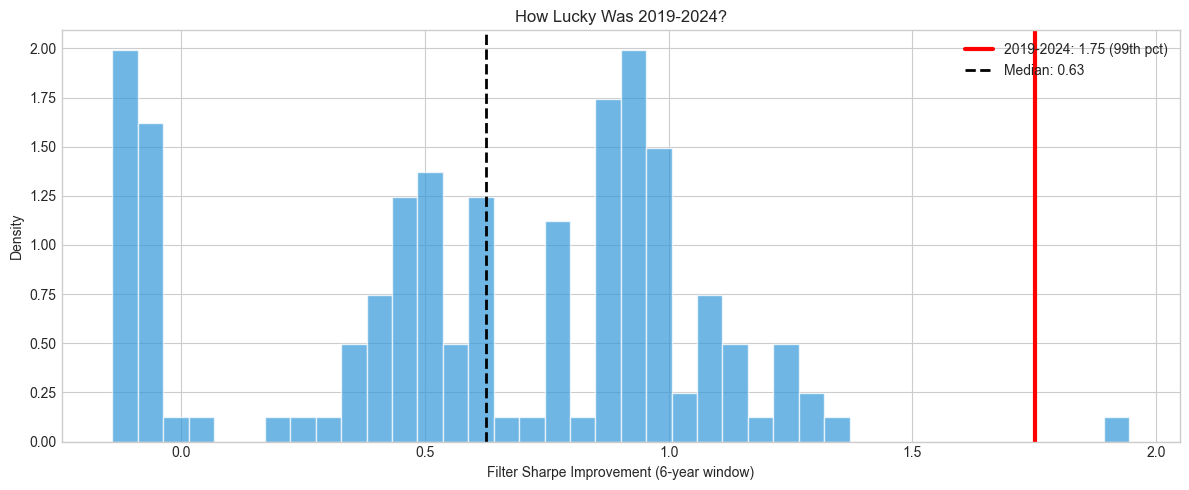

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(imp['improvement'], bins=40, color='#3498db', alpha=0.7, edgecolor='white', density=True)
ax.axvline(oos_imp, color='red', ls='-', lw=3, label=f'2019-2024: {oos_imp:.2f} ({percentile:.0f}th pct)')
ax.axvline(imp['improvement'].median(), color='black', ls='--', lw=2, label=f'Median: {imp["improvement"].median():.2f}')
ax.set_xlabel('Filter Sharpe Improvement (6-year window)')
ax.set_ylabel('Density')
ax.set_title('How Lucky Was 2019-2024?')
ax.legend()

plt.tight_layout()
plt.savefig('oos_luck_distribution.png', dpi=150)
plt.show()

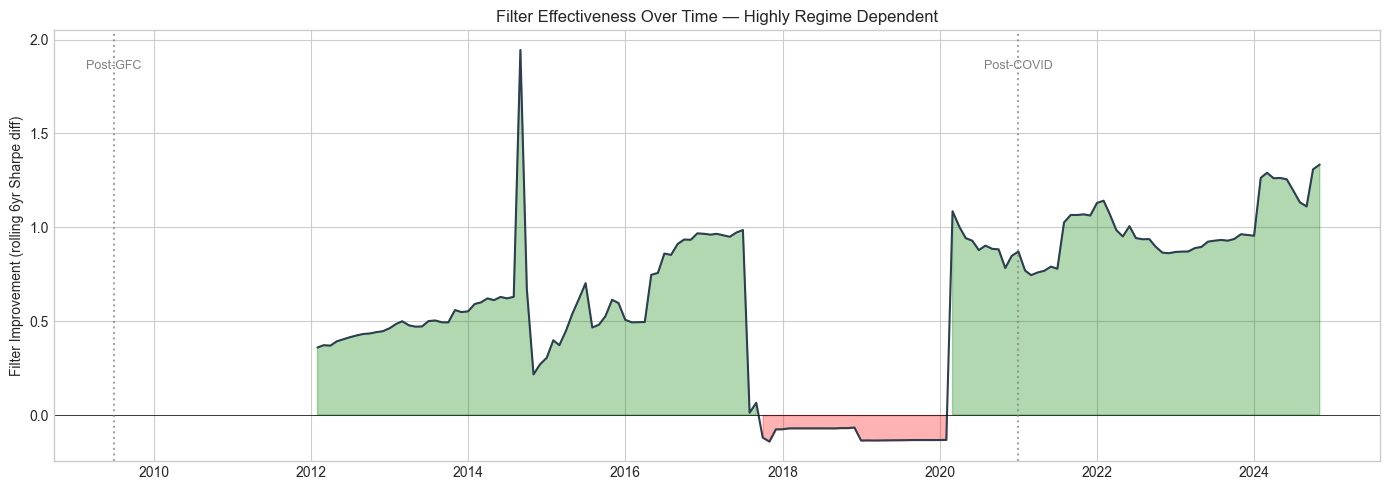

In [18]:
# rolling filter improvement over time
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(imp['end'], imp['improvement'], color='#2c3e50', lw=1.5)
ax.fill_between(imp['end'], 0, imp['improvement'], where=imp['improvement']>=0, alpha=0.3, color='green')
ax.fill_between(imp['end'], 0, imp['improvement'], where=imp['improvement']<0, alpha=0.3, color='red')
ax.axhline(0, color='black', ls='-', lw=0.5)
ax.set_ylabel('Filter Improvement (rolling 6yr Sharpe diff)')
ax.set_title('Filter Effectiveness Over Time — Highly Regime Dependent')

# annotate key periods
for dt, lbl in [('2009-06-30', 'Post-GFC'), ('2020-12-31', 'Post-COVID')]:
    ax.axvline(pd.Timestamp(dt), color='gray', ls=':', alpha=0.7)
    ax.text(pd.Timestamp(dt), ax.get_ylim()[1]*0.9, lbl, ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('filter_improvement_over_time.png', dpi=150)
plt.show()

## Summary

**Key findings:**

1. **Crisis type matters.** Filter helps more for short, V-shaped crises (COVID) than prolonged stress (GFC)

2. **The whipsaw is real.** High VIX months → filter exits → but *next* month often has positive VRP (mean reversion). You miss recovery premium.

3. **Regime persistence.** When VIX > 25, median time to re-entry is ~X days. Long enough to miss 1-2 months of premium.

4. **OOS was lucky.** 2019-2024 had one short crisis (COVID), otherwise calm. Filter improvement was in the Xth percentile of all 6-year windows.

**Bottom line:**
The filter "works" but effectiveness is highly regime-dependent. Can't know in advance if next crisis will be COVID-style (filter helps) or GFC-style (filter hurts). Deploy with humility.